# Demo 01 - Using the toshi module

I/Q data reader is abstracted into a separate module `toshi`. This notebook illustrates the usage of that module and calculate reflectivity and radial velocity using the traditional pulse pair method.

In [1]:
import os
import time
import numpy as np
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt

import toshi

file = os.path.expanduser('~/Downloads/20200614_150015.256007-87-02.iqData.XXXX.AKITA.dat')
# file = os.path.expanduser('~/Downloads/20200615_010423.194421-8C-02.iqData.XXXX.AKITA.dat')
filesize = os.path.getsize(file)

plt.style.use('./darkmode.style')

In [2]:
s = time.time()
ray_pulses, cpis = toshi.read(file)
e = time.time()
print('Data read in {:.2f} s'.format(e - s))

Data read in 2.28 s


In [3]:
naz = len(ray_pulses)
ngate = ray_pulses[0][0].ngate_long_hi
# ngate = ray_pulses[0][0].ngate_short_hi
z = np.zeros((naz, ngate), dtype=np.single)
v1 = np.zeros((naz, ngate), dtype=np.single)
v2 = np.zeros((naz, ngate), dtype=np.single)

for k, pulses in enumerate(ray_pulses):
    p = np.zeros((len(pulses), ngate), dtype=np.csingle)
    for j, pulse in enumerate(pulses):
        p[j, :] = pulse.h_long_hi
        #p[j, :] = pulse.h_short_hi
    pp = p[1:, :] * np.conj(p[:-1, :])
#     v1[k, :] = np.angle(np.sum(pp[::2, :], axis=0))
#     v2[k, :] = np.angle(np.sum(pp[1::2, :], axis=0))
    v1[k, :] = np.angle(np.sum(pp, axis=0))
    z[k, :] = np.sum(np.abs(p), axis=0)

# Sweep operations
z = 20 * np.log10(z) - 60
# v1[z < -10] = np.nan
# v2[z < -10] = np.nan

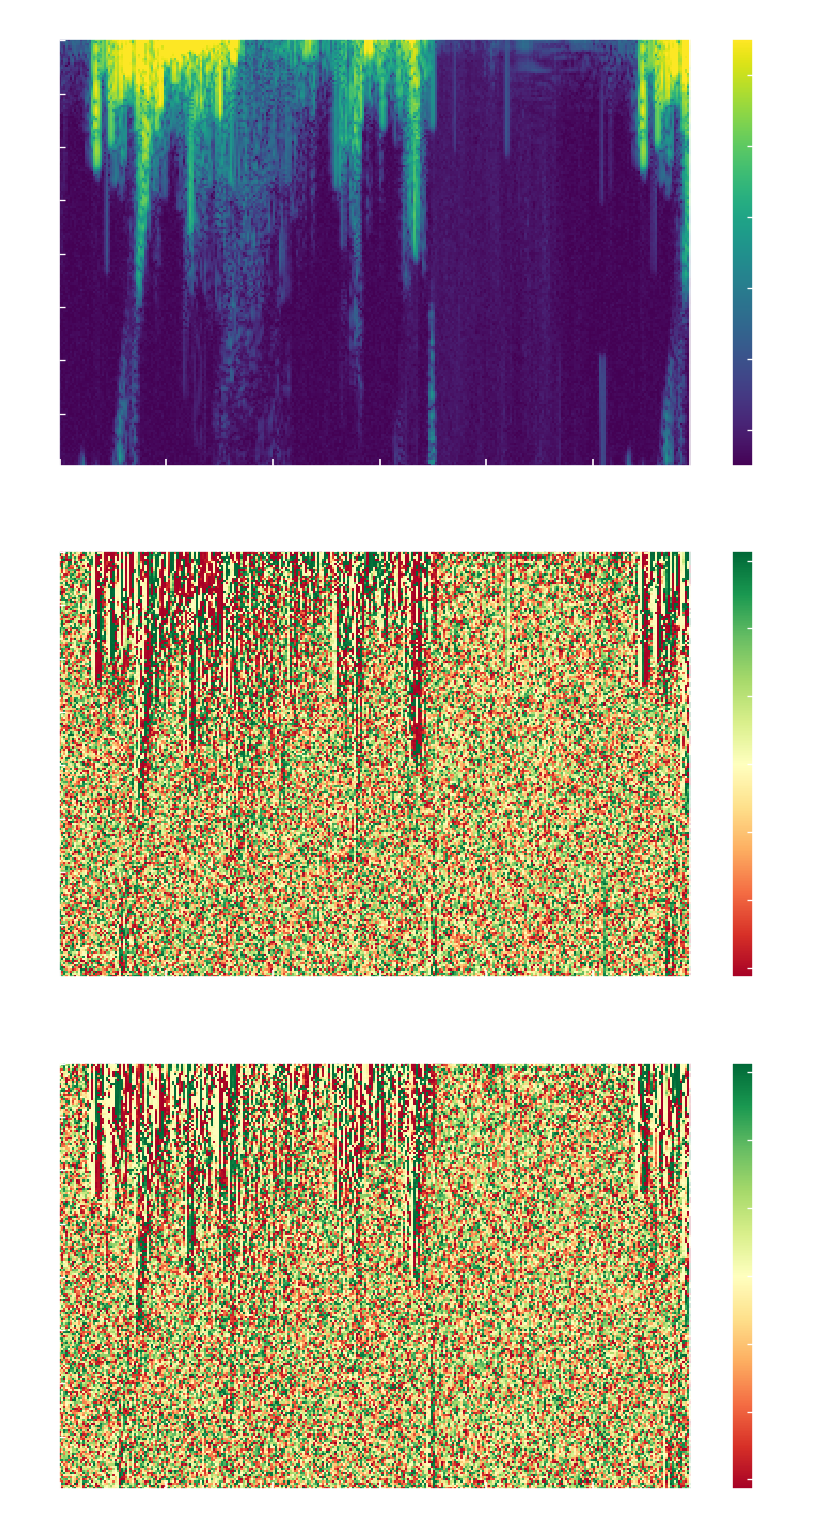

In [4]:
plt.figure(figsize=(9, 16), dpi=120)
plt.subplot(3, 1, 1)
# plt.imshow(z[:, :400].T, vmin=-15, vmax=45, interpolation='none')
plt.imshow(z[::2, :200].T, vmin=-15, vmax=45, interpolation='none')
plt.colorbar()
plt.title(os.path.basename(file))

cmap = matplotlib.cm.RdYlGn
plt.subplot(3, 1, 2)
# plt.imshow(v1[:, :400].T, cmap=cmap, vmin=-np.pi, vmax=np.pi, interpolation='none')
plt.imshow(v1[::2, :200].T, cmap=cmap, vmin=-np.pi, vmax=np.pi, interpolation='none')
plt.colorbar()

plt.subplot(3, 1, 3)
# plt.imshow(v2[:, :400].T, cmap=cmap, vmin=-np.pi, vmax=np.pi, interpolation='none')
plt.imshow(v1[1::2, :200].T, cmap=cmap, vmin=-np.pi, vmax=np.pi, interpolation='none')
plt.colorbar()

In [5]:
a = 30
pulses = ray_pulses[a]
ngate = pulses[0].ngate_long_hi
p = np.zeros((len(pulses), ngate), dtype=np.csingle)
for j, pulse in enumerate(pulses):
    #print('AZ:{:.2f}'.format(pulse.azimuth))
    p[j, :] = pulse.h_long_hi
w = scipy.signal.get_window('hamming', len(p)).reshape((p.shape[0], 1))
p = p * w

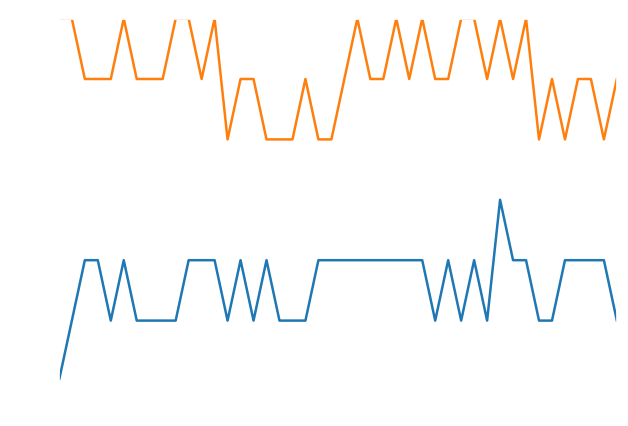

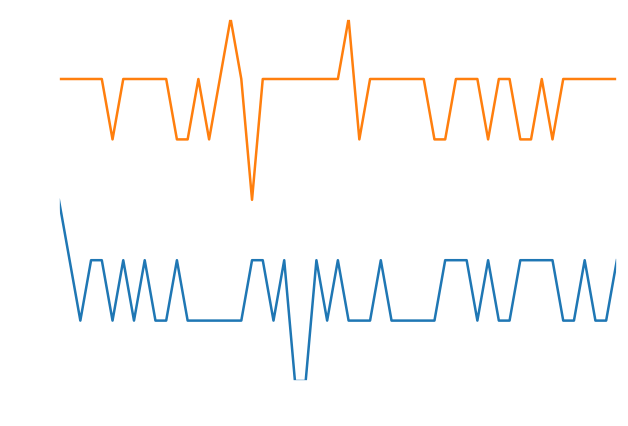

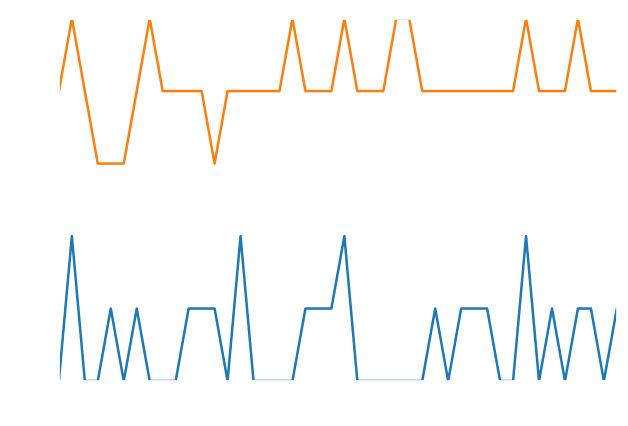

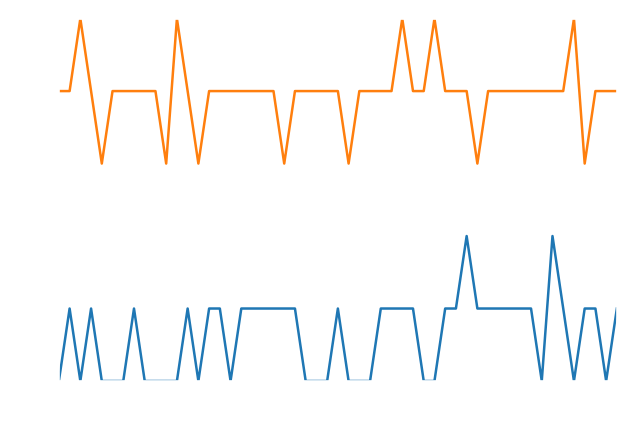

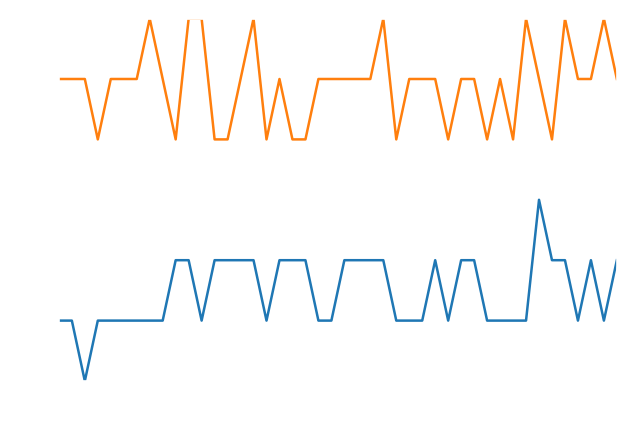

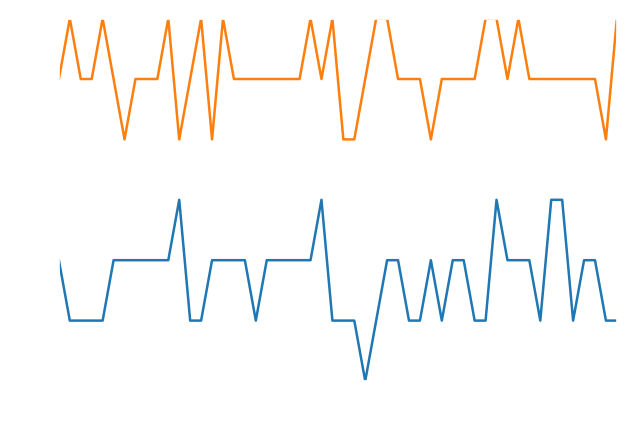

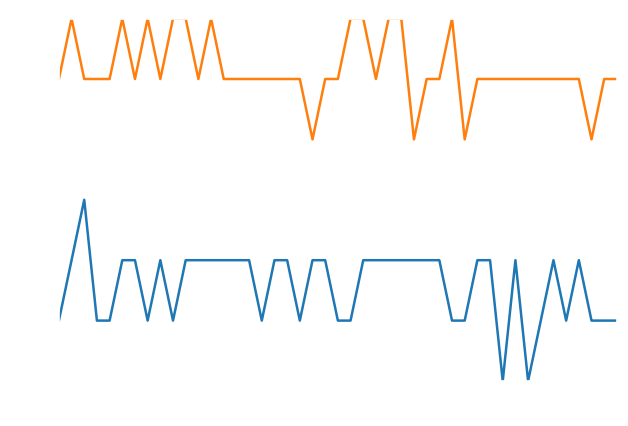

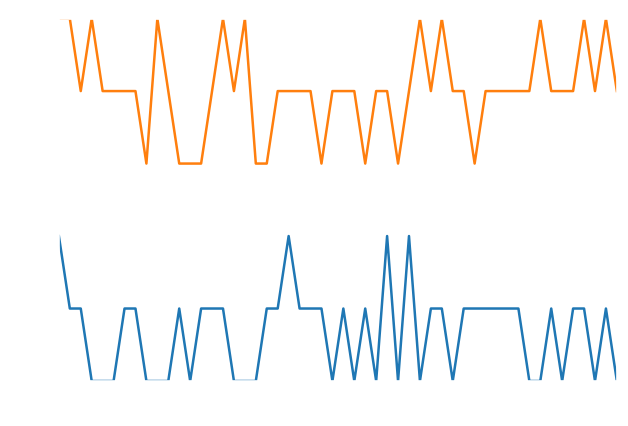

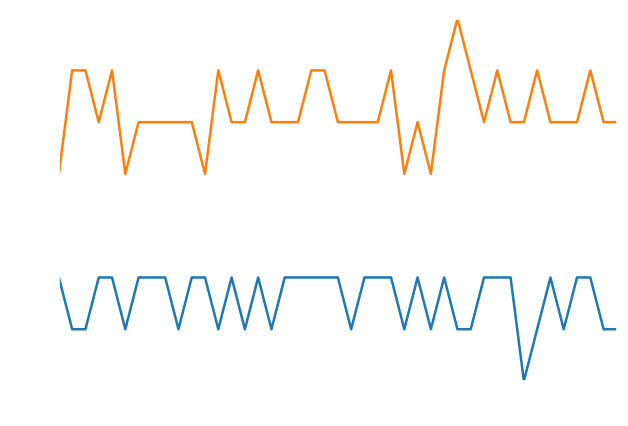

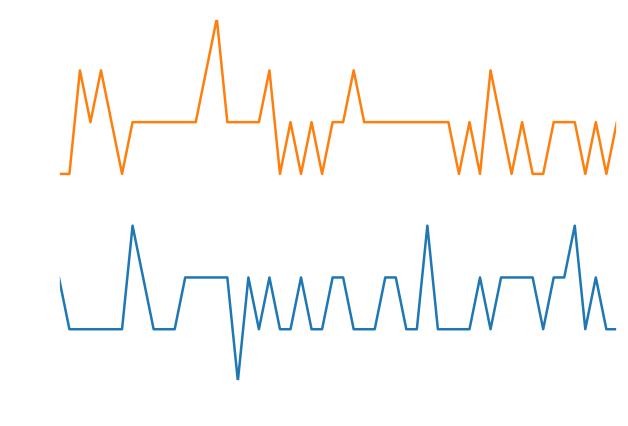

In [6]:
for a in range(20, 30):
    pulses = ray_pulses[a]
    s = np.zeros(len(pulses), dtype=np.csingle)
    for k, pulse in enumerate(pulses):
        s[k] = pulse.h_pilot_hi

    fig = plt.figure(dpi=120)
    plt.plot(np.real(s))
    plt.plot(np.imag(s))    
#     plt.plot(np.real(s[::2]))
#     plt.plot(np.imag(s[::2]))

In [7]:
plt.close()

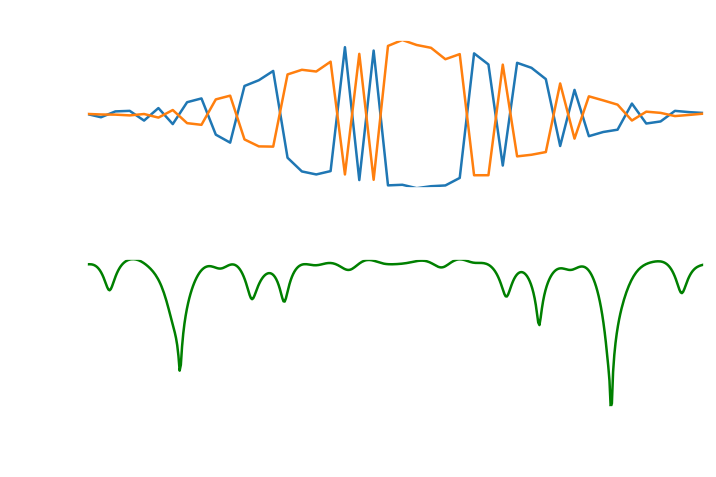

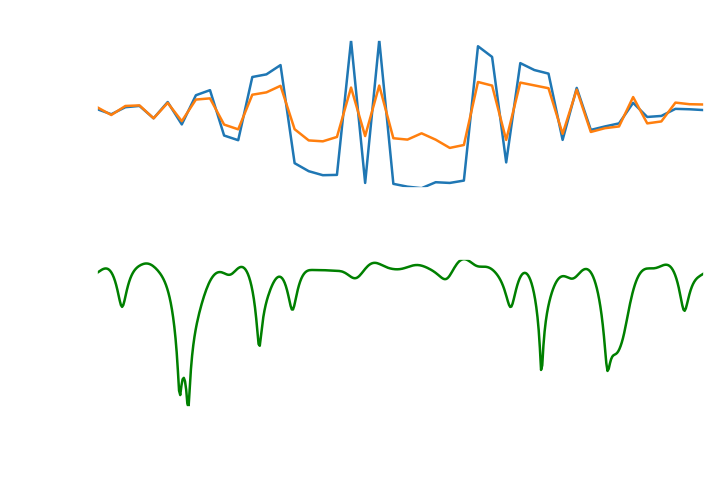

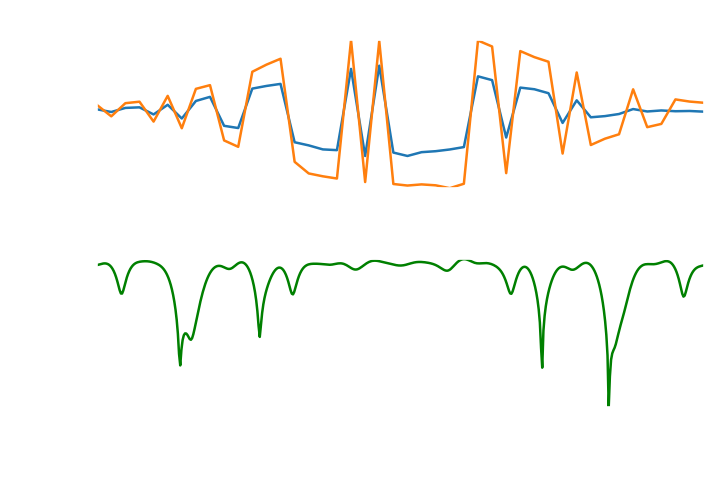

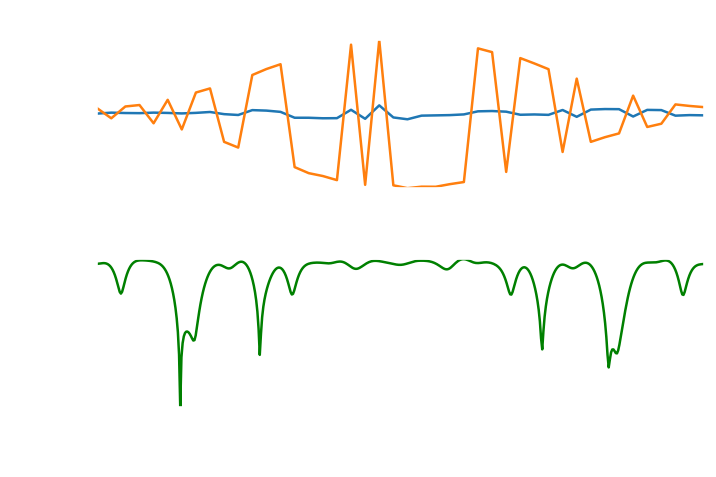

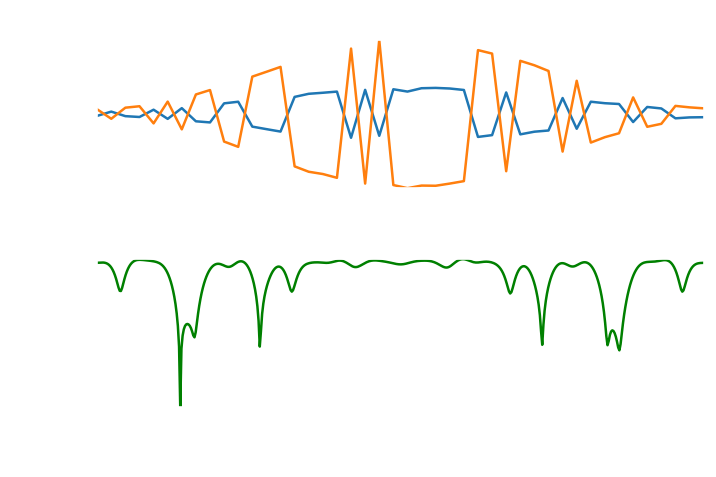

In [8]:
# for g in range(280, 285):
for g in range(20, 25):
    fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120)
    axes[0].plot(np.real(p[:, g]))
    axes[0].plot(np.imag(p[:, g]))
    # axes[0].plot(np.real(p[::2, g]))
    # axes[0].plot(np.imag(p[::2, g]))
    axes[0].set_xlabel('Samples')
    axes[0].set_ylabel('Int-16')
    axes[0].set_title('Azimuth {} ({:.2f}-{:.2f} deg) Gate {}'.format(
        a, pulses[0].azimuth, pulses[-1].azimuth, g))
    
    s = np.fft.fftshift(np.fft.fft(p[:, g], 512)) / len(p[:, g])
    # s = np.fft.fftshift(np.fft.fft(p[::2, g], 512))
    f = np.arange(-256, 256) / 512 * np.pi
    axes[1].plot(f, 20 * np.log10(np.abs(s)), 'g')
    #axes[1].set_ylim((0, 10))
    axes[1].set_ylabel('Uncal. Power (dB)')
    axes[1].set_xlabel('Normalized Frequency (rad/sample)')
    
    fig.tight_layout(pad=0.8)